Dokumentacja:
https://docs.atlassian.com/jira-software/REST/7.3.1/

FYI:
- stories issues to takie które zawierają subtaski

In [1]:
# Work still in progress

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import requests 
from requests.auth import HTTPBasicAuth
import json 
from pprint import pprint

auth = HTTPBasicAuth("piotrkica@student.agh.edu.pl", "jira credentials here")
headers = {"Accept": "application/json"} 

In [5]:
# SPRINT DATA
def get_all_sprints_data(board_id=1):
    url = f"https://bugajski.atlassian.net/rest/agile/1.0/board/{board_id}/sprint" 
    response = requests.request("GET", url, headers=headers, auth=auth) 
    sprints_data = json.loads(response.text)
    return sprints_data

sprints_data = get_all_sprints_data()

# Wartości dla osi x na wykresie
sprints_start_dates = [(sprint["name"], sprint["startDate"]) for sprint in sprints_data["values"]]
sprints_end_dates = [(sprint["name"], sprint["endDate"]) for sprint in sprints_data["values"]]
print(sprints_start_dates)
print(sprints_end_dates)

[('PVD Sprint 0', '2022-03-25T14:49:34.446Z'), ('PVD Sprint 1', '2022-04-01T13:25:34.315Z')]
[('PVD Sprint 0', '2022-04-01T14:49:00.000Z'), ('PVD Sprint 1', '2022-05-06T12:30:00.000Z')]


In [6]:
def get_specific_sprint_issues(sprint_id=2):  # sprint zerowy to 1
    url = f"https://bugajski.atlassian.net/rest/agile/1.0/board/1/sprint/{sprint_id}/issue?maxResults=200" 
    response = requests.request("GET", url, headers=headers, auth=auth) 
    sprint_issues = json.loads(response.text)
    
    return sprint_issues

sprint_issues = get_specific_sprint_issues()
# pprint(sprint_issues)  # dict wszystkich issue w danym sprincie, uwaga spory

In [7]:
def get_stories_issues(sprint_issues):
    # Inaczej mówiąc wszystkie issue które mają subtaski 
    # W celu wyjęcia pola "customfield_10026" zawierający wartość story_points danego issue
    stories_issues = [issue for issue in sprint_issues["issues"] if len(issue["fields"]["subtasks"]) > 0]
    return stories_issues

stories_issues = get_stories_issues(sprint_issues)

In [8]:
url = "https://bugajski.atlassian.net/rest/api/2/issue/10084" 
response = requests.request("GET", url, headers=headers, auth=auth) 
resp = json.loads(response.text)#, sort_keys=True, indent=4, separators=(",", ": "))  #json.dumps(

In [9]:
def count_done_subtasks_in_issue(story_issue):
    n_done = 0
    for issue in story_issue["subtasks"]:
        status = issue["fields"]["status"]
        if status["statusCategory"]["key"] == 'done':
            n_done += 1
    return n_done

count_done_subtasks_in_issue(stories_issues[0]["fields"])

1

In [10]:
def get_sprint_total_points(stories_issues):
    total_points = 0
    for s_issue in stories_issues:
        total_points += s_issue["fields"]["customfield_10026"]
        
    return total_points

get_sprint_total_points(stories_issues)

82.0

In [11]:
def get_issue_end_date(url):
    response = requests.request("GET", url, headers=headers, auth=auth) 
    issue_data = json.loads(response.text)
    resolution_date = issue_data["fields"]["resolutiondate"]  # also valid field: "statuscategorychangedate"
    
    return resolution_date 

pprint(get_issue_end_date('https://bugajski.atlassian.net/rest/api/2/issue/10023'))

None


In [12]:
def get_sprint_summary_dataframe(stories_issues):
    df = pd.DataFrame([], columns=['story_issue_key', 'story_points', 'subtasks_no', 'subtask_key', 'subtask_end_date', "subtask_summary"])
    done_points = 0
    for s_issue in stories_issues:  #todo async
        issue_key = s_issue["key"]
        story_points = s_issue["fields"]["customfield_10026"]
        all_subtasks = len(s_issue["fields"]["subtasks"])
        
        pprint(issue_key)
        pprint(story_points)
        pprint(all_subtasks)
            
            
        for subtask in s_issue["fields"]["subtasks"]:
            subtask_key = subtask["key"]
            url = subtask["self"]
            subtask_summary = subtask["fields"]["summary"]
            subtask_end_date = get_issue_end_date(url)
            
            
            df.loc[df.shape[0]] = (issue_key, story_points, all_subtasks, subtask_key, subtask_end_date, subtask_summary)
            
    df['subtask_end_date'] = pd.to_datetime(df["subtask_end_date"]).dt.strftime('%d-%m-%Y')
    return df

df = get_sprint_summary_dataframe(stories_issues)

'PVD-23'
13.0
9
'PVD-70'
3.0
8
'PVD-91'
3.0
5
'PVD-49'
2.0
6
'PVD-90'
5.0
6
'PVD-56'
13.0
13
'PVD-80'
3.0
4
'PVD-85'
40.0
4


In [21]:
min_date = pd.to_datetime('01-03-2022', format='%d-%m-%Y')
max_date = pd.to_datetime('01-06-2022', format='%d-%m-%Y')

d = (max_date - min_date).days + 1

df2 = df.copy()
df2['subtask_end_date'] = min_date + pd.to_timedelta(pd.np.random.randint(d,size=55), unit='d')

C:\Users\Piotrek\AppData\Local\Temp\ipykernel_15292\918522704.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df2['subtask_end_date'] = min_date + pd.to_timedelta(pd.np.random.randint(d,size=55), unit='d')


In [22]:
df.sort_values("subtask_end_date")[:12]

,story_issue_key,story_points,subtasks_no,subtask_key,subtask_end_date,subtask_summary
8,PVD-23,13.0,9,PVD-103,15-04-2022,Stworzyć bazę danych jako serwis docker-compose
0,PVD-23,13.0,9,PVD-24,NaN,Stworzyć kolekcję użytkowników
1,PVD-23,13.0,9,PVD-25,NaN,Stworzyć UX/UI do rejestracji i logowania
2,PVD-23,13.0,9,PVD-26,NaN,Stworzyć Front-end do rejestracji
3,PVD-23,13.0,9,PVD-27,NaN,Stworzyć Front-end do logowania i wylogowania
4,PVD-23,13.0,9,PVD-28,NaN,Stworzyć Back-end do rejestracji użytkowników
5,PVD-23,13.0,9,PVD-29,NaN,Stworzyć Back-end do logowania i wylogowania u...
6,PVD-23,13.0,9,PVD-30,NaN,Stworzyć session control na Front-endzie
7,PVD-23,13.0,9,PVD-31,NaN,Research o oAuth2
9,PVD-70,3.0,8,PVD-71,NaN,Zaprojektować UI/UX strony z ustawieniami


In [23]:
def get_burndown_df(df):
    burndown_df = pd.DataFrame([], columns = ["total", "date"])
    
    total = int(df.groupby("story_issue_key")["story_points"].agg('unique').sum())
    df = df.sort_values("subtask_end_date")
    df = df.reset_index(drop=True)

    for row in range(df.shape[0]):
        if df["subtask_end_date"][row] == None:
            break
        total -= df["story_points"][row] / df["subtasks_no"][row]
        burndown_df.loc[burndown_df.shape[0]] = (total, df["subtask_end_date"][row])
    
    burndown_df['total'] = burndown_df['total'].apply('{:.2f}'.format).astype(float)
    return burndown_df

bdf = get_burndown_df(df2)

In [24]:
datelist = pd.date_range(bdf["date"].min(), bdf["date"].max(), periods=4).tolist()
datelist

[Timestamp('2022-03-02 00:00:00'),
 Timestamp('2022-03-31 16:00:00'),
 Timestamp('2022-04-30 08:00:00'),
 Timestamp('2022-05-30 00:00:00')]

In [178]:
print(bdf["date"].max())

2022-05-31 00:00:00


<IPython.core.display.Javascript object>


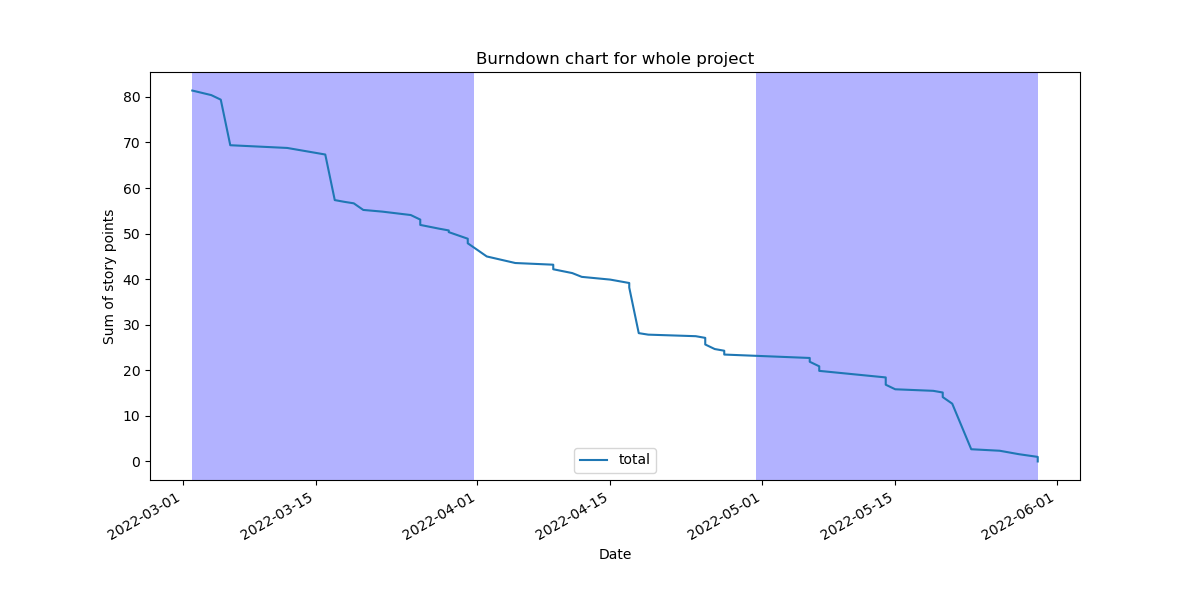

In [30]:
def plot_burndown(burndown_df):
    sprints = pd.date_range(bdf["date"].min(), bdf["date"].max(), periods=4).tolist()
    bdf.plot.line(x="date", y="total", xlabel = "Date", ylabel = "Sum of story points", figsize=(12,6), title="Burndown chart for whole project");
    for i in range(0, len(sprints)-1, 2):
        plt.axvspan(sprints[i], sprints[i+1], facecolor='b', alpha=0.3)

plot_burndown(bdf)